In [1]:
%matplotlib inline
import numpy as np
from numba import jit
from matplotlib import pyplot as plt
import seaborn as sns

We set parameter values

In [2]:
l_vec = np.array([0.1, 1, 1.25])
Z = 0.1
alpha = 0.3
B = 0.1
b_max = 2;
beta = 0.95;
N_b = 501;
T = 20000;
psi = 0.0001
K_0 = 0.398

nlsize = 3;
P = np.array([[.4,.5,.1],[.2, .7, .1],[.2, .1, .7]])
epsilon = 0.25
mu = 0.03

tol_inner = 1e-6
tol_outer = 1e-6
tol = 1e-6

Ergodic density of individuals over productivity states

In [3]:
def calc_ergodic_density():
    H = P
    for i in range(1000):
        H_new = H.dot(P)
        error = np.max(H - H_new)
        if error < tol:
            return H_new    
        H = H_new;
    return None

f = calc_ergodic_density()[0,:]

Aggregate labor

In [4]:
L = f.dot(l_vec)

Asset grid

In [5]:
agrid = np.linspace(-B, b_max, N_b); 
apgrid = np.linspace(-B, b_max, N_b);

In [6]:
def calc_prices(K):
    r = Z * alpha * (K**(alpha-1)) * (L**(1-alpha))
    w = Z * (1-alpha) * (K**alpha) * (L**(-alpha))
    utilgrid = np.zeros((N_b, N_b, nlsize))
    for a in range(N_b):
        for ap in range(N_b):
            for l in range(nlsize):
                consumption = (1+r) * agrid[a] + w * l_vec[l] - apgrid[ap]
                if consumption <= 0:
                    utilgrid[a,ap,l] = -1000
                else:
                    utilgrid[a,ap,l] = np.log(consumption)
    return utilgrid, r, w

In [7]:
opt_calc_prices = jit(calc_prices)

In [8]:
def vfi_func(utilgrid, initial_V):
    V = initial_V.copy()
    V_new = V.copy()
    index = np.zeros((N_b, nlsize))
    for i in range(1000):
        for a in range(N_b):
            for z in range(nlsize):
                index[a,z] = np.argmax(utilgrid[a,:,z] + beta * np.dot(P[z,:], V.T))
                V_new[a,z] = np.max(utilgrid[a,:,z] + beta * np.dot(P[z,:], V.T))
        error_inner = np.max(np.abs(V - V_new).flatten()) 
        if error_inner < tol_inner:
            return V_new, index.astype(int)
        V = V_new.copy()
    return None

In [9]:
def calc_policy(index, r, w):
    a_policy = agrid[index]
    return a_policy

In [10]:
def calc_simulation(a_policy):
    l_sim = np.zeros((T, 1))
    l_sim[0] = l_vec[1]
    l_sim_index = np.zeros((T, 1), dtype = int)
    l_sim_index[0] = 1
    rand_nums = np.random.rand(T)
    for i in range(1, T):
        dist = P[l_sim_index[i-1], :]
        cum_dist = np.cumsum(dist)
        r = rand_nums[i]
        l_sim_index[i] = np.argwhere(cum_dist > r)[0]
        l_sim[i] = l_vec[l_sim_index[i]]
    asim = np.zeros((T, 1))
    asim[0] = agrid[250]
    asim_index = np.zeros((T, 1), dtype = int)
    asim_index[0] = 250
    for t in range(1, T):
        asim[t] = a_policy[asim_index[t-1], l_sim_index[t]]
        asim_index[t] = np.argwhere(agrid == asim[t])
    K_new = np.mean(asim[(T//5):])
    #K_d = ((r / (Z * alpha)) ** (1/(alpha - 1)))*L
    return asim_index, l_sim_index, K_new

In [11]:
opt_calc_simulation = jit(calc_simulation)

In [12]:
def full_loop(n_iter=1000, initial_k = K_0):
    K = initial_k
    for t_outer in range(n_iter):
        value_func = np.zeros((N_b, nlsize))
        utilgrid, r, w = opt_calc_prices(K)
        value_func, p_index = vfi_func(utilgrid, value_func)
        a_policy = calc_policy(p_index, r, w)
        asim_index, l_sim_index, K_new = calc_simulation(a_policy)
        K_update = psi*K_new + (1-psi)*K
        if np.max(np.abs(K_update - K)) < tol_outer:
            r = Z * alpha * (K**(alpha-1)) * (L**(1-alpha))
            w = Z * (1-alpha) * (K**alpha) * (L**(-alpha))
            return K, w, r, asim_index, l_sim_index, value_func, p_index
        print(K)
        K = K_update
    return None

In [13]:
some_results = full_loop(initial_k=0.398)

0.398
0.397993113684
0.397982028975
0.397974079703
0.397961968869
0.397957041535
0.397953866014
0.397944889981
0.397934106352
0.397926135702
0.397915253437
0.397909190343
0.397894342741
0.397884134002
0.397872214049
0.39786093311
0.397855261296
0.397850600623
0.397841412001
0.397833812739
0.39782861241
0.397818037205
0.397814714279


In [14]:
some_results[0]

0.39780871289884506

In [15]:
some_results[1]

0.055989282125253045

In [16]:
some_results[2]

0.050517120009390473

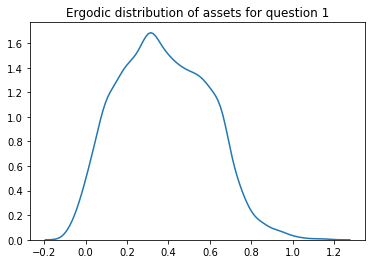

In [21]:
sns.distplot(agrid[some_results[3]], hist=False)
plt.title("Ergodic distribution of assets for question 1")
plt.show()

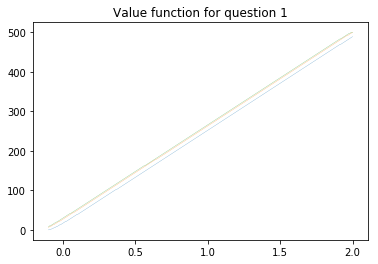

In [20]:
plt.plot(agrid, some_results[6][:, 0], lw = 0.2, label = "Low productivity")
plt.plot(agrid, some_results[6][:, 1], lw = 0.2, label = "Medium productivity")
plt.plot(agrid, some_results[6][:, 2], lw = 0.2, label = "High productivity")
plt.title("Value function for question 1")
plt.show()